In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib numpy scikit-learn seaborn

In [48]:
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [49]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [50]:
gpus

[]

In [51]:
data_dir = 'model/hand_data'
os.listdir(data_dir)


['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']

## Building data pipeline

In [52]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='int',  # Assuming integer-encoded labels
    image_size=(256, 256),  # Specify desired image size
    batch_size=32,  # Define batch size
    shuffle=True  # Shuffle the dataset
)

Found 36000 files belonging to 12 classes.


To access our data pipeline

In [53]:
data_iterator = data.as_numpy_iterator()

Accessing data pipeline

In [54]:
batch =data_iterator.next()
batch

(array([[[[ 29.453125,  45.453125,  43.71875 ],
          [ 40.359375,  51.828125,  47.46875 ],
          [ 45.765625,  57.421875,  50.4375  ],
          ...,
          [ 27.015625,  46.84375 ,  49.890625],
          [ 35.34375 ,  57.9375  ,  58.65625 ],
          [ 29.265625,  56.046875,  48.6875  ]],
 
         [[ 36.921875,  53.890625,  55.015625],
          [ 37.96875 ,  50.421875,  45.6875  ],
          [ 51.90625 ,  64.71875 ,  54.359375],
          ...,
          [ 30.5     ,  50.8125  ,  47.875   ],
          [ 38.359375,  60.796875,  52.796875],
          [ 35.296875,  59.5     ,  43.734375]],
 
         [[ 38.515625,  56.140625,  56.359375],
          [ 34.40625 ,  48.125   ,  42.09375 ],
          [ 61.453125,  74.8125  ,  62.984375],
          ...,
          [ 28.875   ,  49.875   ,  43.15625 ],
          [ 29.109375,  50.53125 ,  38.8125  ],
          [ 30.296875,  50.734375,  33.890625]],
 
         ...,
 
         [[  8.59375 ,  21.734375,  27.71875 ],
          [  9.75 

In [55]:
len(batch)

2

Images represented as np arrays, 0 is the image, 1 is the class

In [56]:
batch[0].shape

(32, 256, 256, 3)

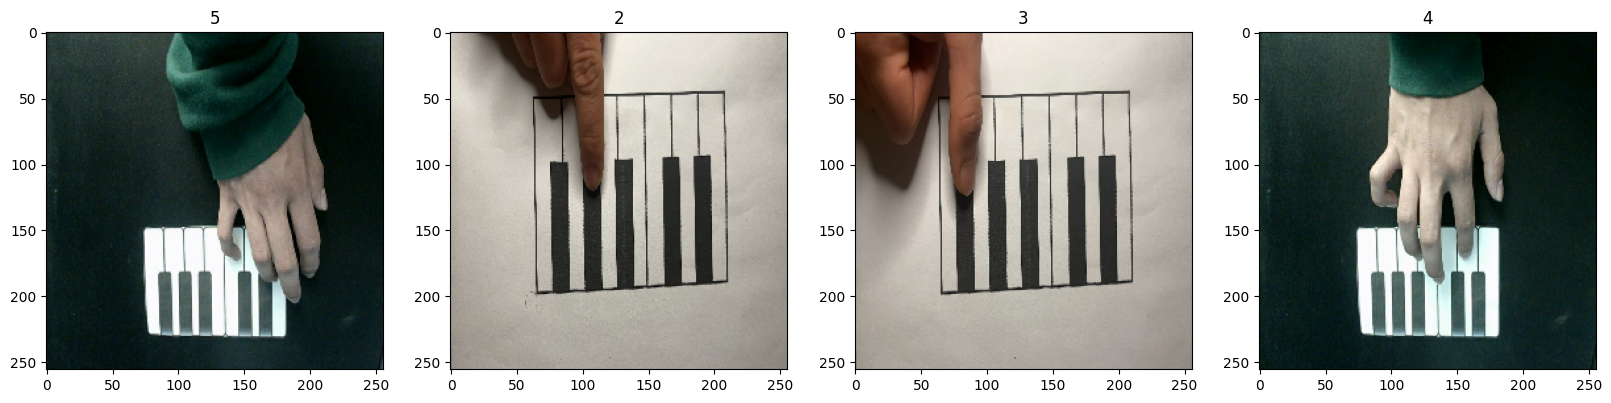

In [57]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessing
map function allows us to preprocess data while it is passing trough data pipeline

In [58]:
data = data.map(lambda x,y: (x/255, y))


In [59]:
scaled_iterator = data.as_numpy_iterator()

In [60]:
batch = scaled_iterator.next()


In [61]:
batch[0].max()

1.0

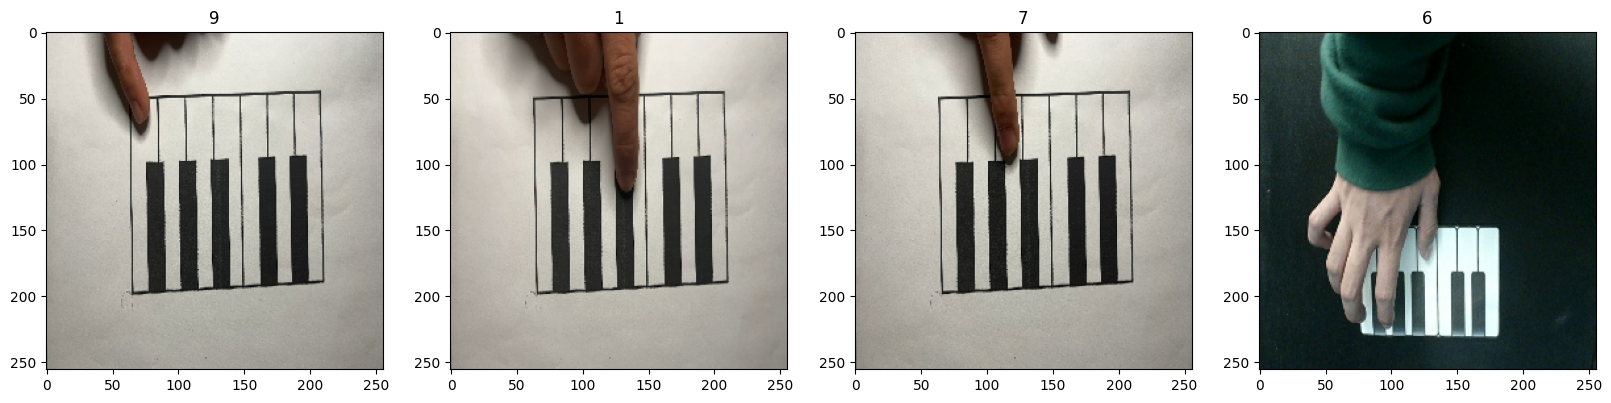

In [62]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Split Model

In [63]:
len(data)

1125

In [64]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [65]:
train_size + val_size +test_size

1125

In [66]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

## CNN model

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

In [68]:
model = Sequential()

# model.add(tf.keras.layers.RandomRotation(factor=0.2, input_shape=(256, 256, 3)))  # Random rotation (max 20% rotation angle)
model.add(tf.keras.layers.RandomContrast(factor=0.2, input_shape=(256, 256, 3)))  # Random contrast adjustment (max 20% contrast change)
# model.add(tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2))  # Random zoom (max 20% zoom)
# model.add(tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2))  # Random translation (max 20% shift)

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(12, activation ='sigmoid'))

In [69]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast_2               │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,587,788 (112.87 MB)

 Trainable params: 29,587,788 (112.87 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [73]:

history = model.fit(train, epochs=10,
                    validation_data=val,
                    callbacks=[tensorboard_callback])

Epoch 1/10


c:\Users\gandr\Documents\vsproj\GitHub\PDS-Piano\.venv\lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


787/787 ━━━━━━━━━━━━━━━━━━━━ 838s 1s/step - accuracy: 0.4981 - loss: 3.6582 - val_accuracy: 0.8582 - val_loss: 0.8869
Epoch 2/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 806s 1s/step - accuracy: 0.8219 - loss: 0.9556 - val_accuracy: 0.9172 - val_loss: 0.6499
Epoch 3/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 756s 959ms/step - accuracy: 0.8433 - loss: 0.8064 - val_accuracy: 0.9347 - val_loss: 0.5595
Epoch 4/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 732s 930ms/step - accuracy: 0.8495 - loss: 0.7415 - val_accuracy: 0.9160 - val_loss: 0.5629
Epoch 5/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 734s 932ms/step - accuracy: 0.8593 - loss: 0.7164 - val_accuracy: 0.9346 - val_loss: 0.5350
Epoch 6/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 727s 924ms/step - accuracy: 0.8641 - loss: 0.6833 - val_accuracy: 0.9329 - val_loss: 0.5289
Epoch 7/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 731s 928ms/step - accuracy: 0.8696 - loss: 0.6662 - val_accuracy: 0.9349 - val_loss: 0.5002
Epoch 8/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 725s 921ms/step - accuracy: 0.8755 - loss: 0.6445 - v

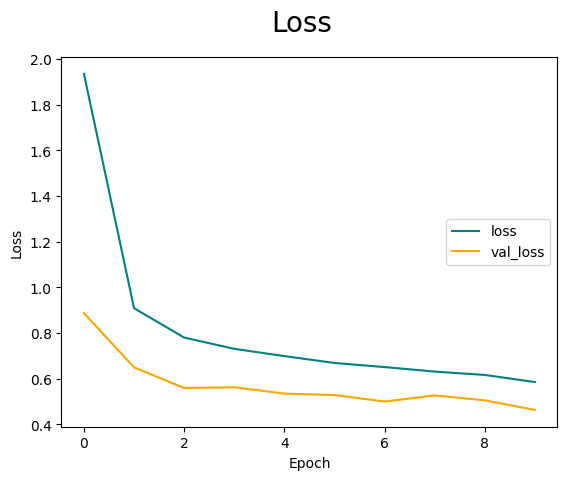

In [74]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color = 'orange', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='right')
plt.show()



113/113 - 60s - 534ms/step - accuracy: 0.9519 - loss: 0.4552
0.9518805146217346


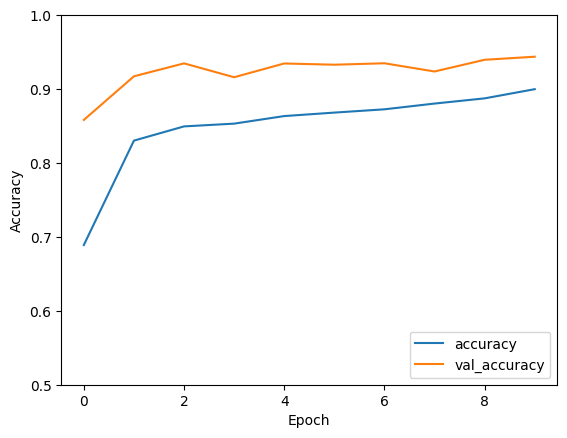

In [75]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test, verbose=2)

print(test_acc)

### Evaluation Metrics

In [76]:
from sklearn.metrics import accuracy_score

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through each batch in the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    
    # Predict the output labels for the input images
    yhat = model.predict(X)
    
    # Convert predicted probabilities to class labels
    predicted_batch_labels = yhat.argmax(axis=1)
    predicted_labels.extend(predicted_batch_labels)
    
    # Extend true_labels directly with class indices
    true_labels.extend(y)
    
    # Print intermediate results for debugging
    print("Batch True Labels:", y)
    print("Batch Predicted Labels:", predicted_batch_labels)

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print("Overall Test Accuracy:", overall_accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Batch True Labels: [ 4  3  8  7  9  1  8 11 10  4  1  1 10 11  7  1  1 10  4 10  2  2  7  5
  4  0  4  1  7  1 11  7]
Batch Predicted Labels: [ 4  3  8  7  9  1  8 11 10  4  1  1 10 11  7  1  1 10  4 10  2  2  7  4
  5  0  4  1  5  1 11  7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Batch True Labels: [ 7  2  4  4 10 10  4  0 10  9  2  2  0  5  7  2  4  3  2  9  2  9  4  7
 11  9  2  0 10  5  5  1]
Batch Predicted Labels: [ 7  2  4  4 10 10  4  0 10  9  2  2  0  5  5  2  4  3  2  9  2  9  4  7
 11  9  2  0 10  5  5  1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Batch True Labels: [ 7  2  3  6  5  6  0  7  7  2  9  7  5  8  3  8  8  6  5  4  1  6 10  8
  5  7  9  7  5  5 11  5]
Batch Predicted Labels: [ 7  2  3  6  5  5  0  7  7  2  9  7  5  8  3  8  8  6  5  4  1  6 10  8
  5  7  9  7  5  5  5  5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Batch True Labels: [10  3  2  1  1  5 10  1  9  6  9  2  4  0  7  0  0  5  3 11  4  0 11  3
  5  7 10  9  2 10  7  5]
Bat

In [77]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


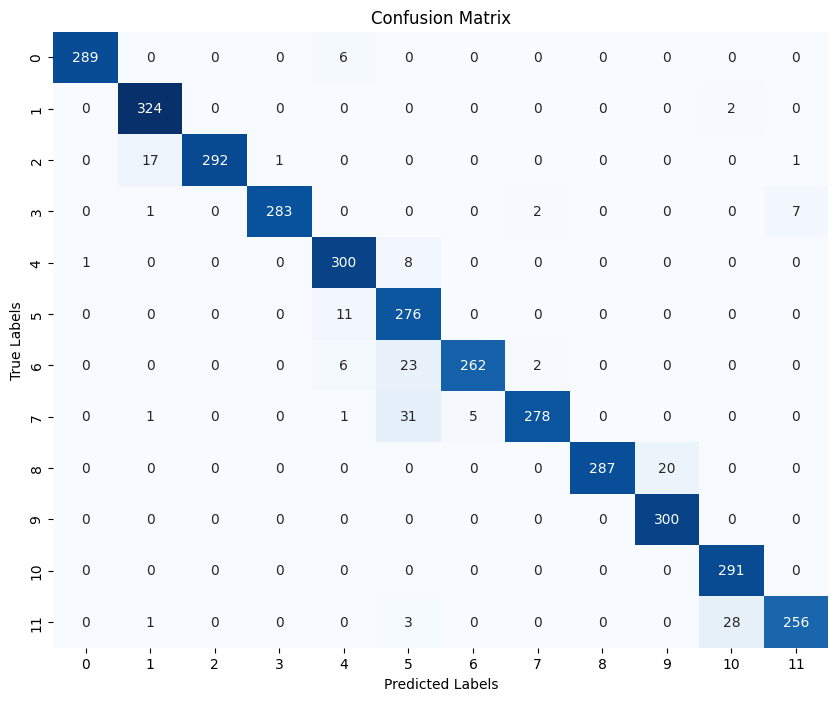

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='macro')  # You can use other averaging methods as well
print("Precision:", precision)

Number of predictions:  3616


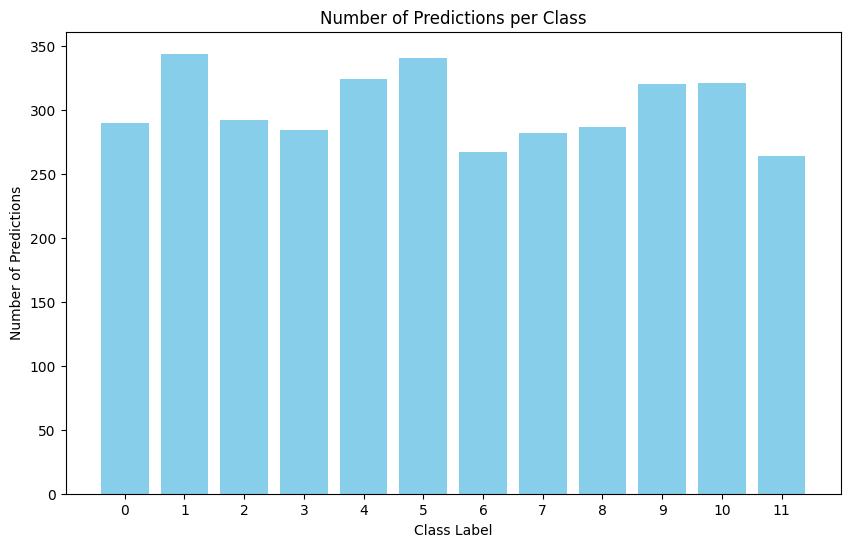

In [80]:
import matplotlib.pyplot as plt

# Count the occurrences of each predicted label
predicted_counts = {}
for label in predicted_labels:
    if label in predicted_counts:
        predicted_counts[label] += 1
    else:
        predicted_counts[label] = 1

# Sort the predicted counts by class label
sorted_predicted_counts = sorted(predicted_counts.items())

# Extract labels and counts
labels, counts = zip(*sorted_predicted_counts)

print('Number of predictions: ', len(predicted_labels))

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Predictions')
plt.title('Number of Predictions per Class')
plt.xticks(labels)
plt.show()


In [81]:
from sklearn.metrics import classification_report

# Calculate classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       295
           1       0.94      0.99      0.97       326
           2       1.00      0.94      0.97       311
           3       1.00      0.97      0.98       293
           4       0.93      0.97      0.95       309
           5       0.81      0.96      0.88       287
           6       0.98      0.89      0.94       293
           7       0.99      0.88      0.93       316
           8       1.00      0.93      0.97       307
           9       0.94      1.00      0.97       300
          10       0.91      1.00      0.95       291
          11       0.97      0.89      0.93       288

    accuracy                           0.95      3616
   macro avg       0.95      0.95      0.95      3616
weighted avg       0.95      0.95      0.95      3616



### Exporting the model

In [82]:
from tensorflow.keras.models import load_model

In [83]:
model.save(os.path.join('model','pianoHand_sigmoid.h5'))

### How to load it

In [84]:
os.path.join('model','pianoHand.h5')

'model\\pianoHand.h5'

In [85]:
new_model = load_model(os.path.join('model','pianoHand_sigmoid.h5'))
# predict = new_predict(X)

In [86]:
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast_2               │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,587,790 (112.87 MB)

 Trainable params: 29,587,788 (112.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [87]:
import os
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np


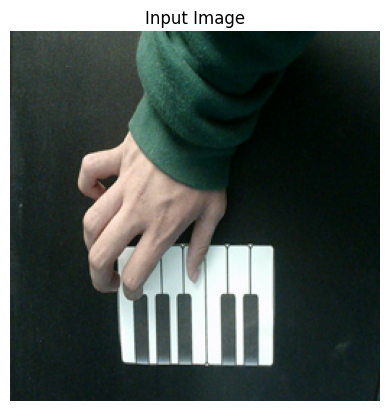

In [94]:
# Define the target input dimensions expected by your model
input_width, input_height = 256, 256  

# Load the image using PIL (Pillow)
image_path = os.path.join('model', 'hand_data', '4', '1501.jpg')
image = Image.open(image_path)

# Resize the image to match the input dimensions of the model
image = image.resize((input_width, input_height))

# Convert the image to a numpy array and normalize pixel values
image_array = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

# Expand the dimensions of the image array to match the input shape expected by the model
input_data = np.expand_dims(image_array, axis=0)

# Display the image using matplotlib
plt.imshow(image_array)
plt.title('Input Image')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [95]:
# Perform inference using the loaded model
predictions = new_model.predict(input_data)

# Assuming a classification task with softmax output, get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Display the predicted class index
print("Predicted Class Index:", predicted_class_index)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class Index: 6


In [96]:
# Perform inference using the loaded model
predictions = new_model.predict(input_data)

# Assuming a classification task with softmax output, get the predicted class probabilities for each class
predicted_class_probabilities = predictions[0]

# Display the predicted class probabilities
for class_index, probability in enumerate(predicted_class_probabilities):
    print(f"Class {class_index}: {probability:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class 0: 0.0026
Class 1: 0.5746
Class 2: 0.0041
Class 3: 0.6233
Class 4: 0.0011
Class 5: 0.4137
Class 6: 0.9938
Class 7: 0.8371
Class 8: 0.0002
Class 9: 0.0190
Class 10: 0.0000
Class 11: 0.0001
